In [1]:
%matplotlib widget

In [ ]:
import numpy as np
import pandas as pd
from shapely.geometry import Point, LineString, MultiPoint, Polygon
from shapely.wkt import loads
from scipy.spatial.ckdtree import cKDTree
import matplotlib.pyplot as plt
import rasterio
import netCDF4
import h5py
import gc, sys, os
import glob
import string
import json
sys.path.append("..\scripts")
import spatial_functions
import aem_utils
import netcdf_utils
import plotting_functions as plots
import ipympl

In [ ]:

# Find the nearest neighbours within the maximum distance

def xy_2_var(grid_dict, xy, var):
    """
    Function for finding a variable for gridded AEM sections
    given an input easting and northing
    @ param: grid_dict :dictionary for gridded line data
    @ param: xy: numpy array with easting and northing
    @ param: var: string with variable name
    returns
    float: distance along line
    """
    utm_coords = np.column_stack((grid_dict['easting'],
                                  grid_dict['northing']))

    d, i = spatial_functions.nearest_neighbours(xy,
                                                utm_coords,
                                                points_required=1,
                                                max_distance=100.)
    if np.isnan(d[0]):
        return None

    else:
        near_ind = i[0]
    


        return grid_dict[var][near_ind]

def in_bounds(coords, b):
    """
    Function return true if point is within raster bounds
    coords = 1d numpy array (x,y)
    b = raseter dataset bounds from rasterio
    """
    x,y = coords[0], coords[1]
    
    if np.all([x > b.left, x < b.right,
                     y > b.bottom, y < b.top]):
        return True
    else:
        return False


        

In [ ]:
# Let create our lciinversion instance
infile = r"C:\Users\PCUser\Desktop\AEM\LCI\DalyR_WB_MGA52.nc"

lci = aem_utils.AEM_inversion(name = 'Laterally Contrained Inversion (LCI)',
                              inversion_type = 'deterministic',
                              netcdf_dataset = netCDF4.Dataset(infile))
# lets load layer grid rasters

# directory with rasters
inRaster = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\2017_DalyRiver_SkyTEM\03_LCI\03_Depth_Slices\Grids_doi_Masked"

lci.load_lci_layer_grids(inRaster, conversion_to_SI = True, nlayers = 30)


In [ ]:
lci.conductivity_data

In [6]:
infile = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\garj_workshop2\DR_rjmcmc_pmaps.nc"

rj = aem_utils.AEM_inversion(name = 'GARJMCMCTDEM',
                              inversion_type = 'stochastic',
                              netcdf_dataset = netCDF4.Dataset(infile))

In [7]:
lci.inversion_type


'deterministic'

In [20]:
import importlib
importlib.reload(plots)


<module 'plotting_functions' from '..\\scripts\\plotting_functions.py'>

In [22]:
# Lets plot the distribution of the points. Clicking on one will return the point index

# This function stores the top of the conductor in the dataframe on a click
def on_map_click(event):
    global point_index
    if event.xdata != None:
        x_, y_ = event.xdata, event.ydata
        distances, indices = spatial_functions.nearest_neighbours([x_,y_], rj.coords, max_distance = 5000.)
        point_index = indices[0]
        

# Do some plotting

fig, ax = plots.AEM_baseplot(rj, lci, layer_number = 5)

cid=  fig.canvas.mpl_connect('button_press_event', on_map_click)

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
point_index

42

In [177]:
# Create modelled boundary object

surface = aem_utils.modelled_boundary(name = 'Oolloo-Jinduckin interface - elevation')

infile = r"C:\Temp\pmap_interp\rj_interp.csv"

surface.load_interpretation_points_from_file(infile)

In [178]:
surface.interpreted_points.keys()

dict_keys(['fiducial', 'easting', 'northing', 'layer_depth', 'layer_elevation', 'standard_deviation'])

In [179]:
# Create our grid

ymin, ymax, = 8420000, 8460000
xmin, xmax = 740000, 778000

surface.create_grid(xmin, xmax, ymin, ymax, cell_size = 500.)
surface.create_interpolator(length_scale = 5000.)
surface.fit_interpolator(variable = 'layer_elevation')
surface.predict_on_grid(convex_hull_buffer = 1000.)

elevation_grid = surface.interpreted_grid

surface.create_interpolator(length_scale = 5000.)
surface.fit_interpolator(variable = 'standard_deviation')
surface.predict_on_grid(convex_hull_buffer = 1000.)

uncertainty_grid = surface.interpreted_grid

In [181]:

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,6))
extent = (xmin, xmax, ymin, ymax)

im1 = ax1.imshow(elevation_grid,extent = extent,
                 vmin = -300, vmax = 0)

cax = fig.add_axes([0.4, 0.6, 0.01, 0.25])

fig.colorbar(im1, cax=cax)

im2 = ax2.imshow(uncertainty_grid, extent = extent,
                vmin = 0., vmax = 50.)

cax2 = fig.add_axes([0.85, 0.6, 0.01, 0.25])

fig.colorbar(im2, cax=cax2)

#ax1.scatter(X[:,0], X[:,1], marker = 'o', c = y.flatten(), 
#            vmin = -300, vmax = 0, edgecolors  = 'k')

#ax2.scatter(X[:,0], X[:,1], marker = 'o', c = y_std.flatten(), 
#            vmin = 0, vmax = 50, edgecolors  = 'k')


plt.show()


<ipython-input-181-86b99946b9ec>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,6))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

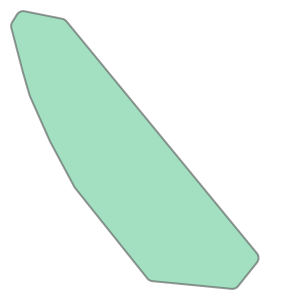

In [103]:
poly = surface.get_convex_hull()
poly

In [110]:
surface.grid_coords

array([[ 740000., 8460000.],
       [ 740000., 8459500.],
       [ 740000., 8459000.],
       ...,
       [ 777500., 8421500.],
       [ 777500., 8421000.],
       [ 777500., 8420500.]])

In [14]:
    
def DR_plot(D, outfile = None):
    fig = plt.figure(figsize = (12,10))

    # These are for interactive widget mode
    fig.canvas.layout.width = '6in'
    fig.canvas.layout.height= '5in'

    ax1 = fig.add_axes([0.05, 0.35, 0.35, 0.62])
    ax2 = fig.add_axes([0.45, 0.35, 0.2, 0.62])
    ax3 = fig.add_axes([0.70, 0.52, 0.2, 0.2])
    ax4 = fig.add_axes([0.72, 0.32, 0.16, 0.16])
    ax5 = fig.add_axes([0.1, 0.18, 0.76, 0.05])
    ax6 = fig.add_axes([0.1, 0.05, 0.76, 0.13])
    ax7 = fig.add_axes([0.70, 0.78, 0.2, 0.2])
    cbar_ax1 = fig.add_axes([0.05, 0.29, 0.35, 0.01])
    cbar_ax2 = fig.add_axes([0.88, 0.05, 0.01, 0.2])
    cbar_ax3 = fig.add_axes([0.9, 0.52, 0.01, 0.2])
    
    panel_kwargs = [{'title': '',
                      'color': 'black',
                      'ylabel': 'data \n residual',
                      'legend': False},
                     {'title': 'LCI conductivity',
                      'max_depth': 500.,
                      'shade_doi': True,
                      'colourbar': True,
                      'colourbar_label': 'Conductivity (S/m)',
                      'log_plot': True,
                      'vmin': 0.001,
                      'vmax': 2.,
                      'cmap': 'jet',
                      'ylabel': 'elevation \n (mAHD)',
                      'vertical_exaggeration': 1.0}]


    # Plot probability map
    
    im = ax1.imshow(D['conductivity_pdf'], extent = D['conductivity_extent'],
                    aspect = 'auto', cmap = 'rainbow')
    
    #  PLot the median, and percentile plots
    ax1.plot(np.log10(D['cond_p10']), D['depth_cells'], c = 'k',linestyle='dashed', label = 'p10')
    ax1.plot(np.log10(D['cond_p90']), D['depth_cells'], c = 'k',linestyle='dashed', label = 'p90')
    ax1.plot(np.log10(D['cond_p50']), D['depth_cells'], c = 'k',label = 'p50')
    ax1.plot(np.log10(D['cond_mean']), D['depth_cells'], c = 'grey',label = 'mean')
    
    ax1.set_xticklabels([round(10 ** float(x), 4) for x in ax1.get_xticks()])

    # for lci layered model we do some processing
    lci_expanded = np.zeros(shape=2 * len(D['lci_cond']) + 1,
                                 dtype=np.float)

    lci_expanded[1:] = np.repeat(D['lci_cond'], 2)

    depth_expanded = (np.max(D['lci_depth_top']) + 10) * np.ones(shape=len(lci_expanded),
                                                            dtype=np.float)

    depth_expanded[:-1] = np.repeat(D['lci_depth_top'], 2)

    ax1.plot(np.log10(lci_expanded), depth_expanded, c = 'pink',
             linestyle = 'dashed', label = 'lci')
    ax1.plot(ax1.get_xlim(), [D['lci_doi'], D['lci_doi']], c = 'yellow',
             label = 'LCI doi')
    ax1.set_title('rj-MCMC probability map')
    ax1.set_ylabel('depth (mBGL)')
    ax1.set_xlabel('Conductivity (S/m)')
    ax1.grid(which = 'both')
    ax1.set_xlim(D['conductivity_extent'][0], D['conductivity_extent'][1] )
    
    ax1.set_ylim(D['conductivity_extent'][2], D['conductivity_extent'][3])#100.,0)#

        
    ax1.legend(loc = 3)
    ax2.plot(D['change_point_pdf'], D['depth_cells'], label = 'P(change point)')
    ax2.set_ylim(ax2.get_ylim()[::-1])
    ax2.set_yticks(np.arange(0, 500, 20.))
    ax2.set_title('change point probability')
    ax2.set_ylim(D['conductivity_extent'][2], D['conductivity_extent'][3])#(100.,0)

    ax2.legend()
    ax2.grid(which = 'both')
    

    sample = D['sample_no'][:]
    
    # Add the misfit
    for i in range(D['misfit'].shape[0]):
       
        misfits = D['misfit'][i]
        ax4.plot(sample, misfits/D['ndata'])

    ax4.plot([1, D['nsamples']], [1,1], 'k')
    ax4.plot([D['burnin'], D['burnin']],[0.1,1e4], 'k')
    ax4.set_xlim([1, D['nsamples']])
    ax4.set_ylim(0.1, 1e4)

    ax4.set_xscale('log')
    ax4.set_yscale('log')

    ax4.set_xlabel("sample #")
    ax4.set_ylabel("Normalised misfit")
    
    im3 = ax3.imshow(elevation_grid,extent = extent, vmin = -300, vmax = 0)
    ax3.scatter(df['easting'].values, df['northing'].values, marker = 'o',
                c = df['layer_elevation'].values, 
                vmin = -300, vmax = 0, edgecolors  = 'k')
    ax3.plot(D['easting'],D['northing'],  'x', c = 'red')

    # conductivity plot
    
    ax7.imshow(np.log10(cond[9]), extent = [cond_dataset.bounds[0],
                                  cond_dataset.bounds[2],
                                  cond_dataset.bounds[1], 
                                  cond_dataset.bounds[3]],
              cmap = 'jet',
              vmin = np.log10(panel_kwargs[1]['vmin']*1000.),
              vmax = np.log10(panel_kwargs[1]['vmax']*1000.))
    
    ax7.set_xlim(D['easting'] - 10000., D['easting'] + 10000.)
    ax7.set_ylim(D['northing'] - 10000., D['northing'] + 10000.)
    ax7.plot(D['easting'],D['northing'],  'x', c = 'k')
    
    p1 = [gridded_vars[line]['easting'][0], gridded_vars[line]['easting'][-1]]
    p2 = [gridded_vars[line]['northing'][0], gridded_vars[line]['northing'][-1]]
    ax7.plot(p1, p2, 'k', linewidth = 0.5)
    ax7.set_title('LCI depth slice 61.8-71.6 mBGL', fontsize=10)
    ax7.tick_params(axis='both', which='major', labelsize=8)
    ax7.tick_params(axis='both', which='minor', labelsize=8)
    cb1 = fig.colorbar(im, cax=cbar_ax1, orientation='horizontal')
    cb1.set_label('probabilitiy', fontsize=10)

    res1 = plot_utils.plot_single_line(ax5, gridded_vars[line],
                                       'data_residual', panel_kwargs[0])

    ax5.set_title('LCI conductivity section - ' + str(line))

    im2 = plot_utils.plot_grid(ax6, gridded_vars[line], 'conductivity',
                               panel_kwargs[1])

    ax6.plot([dist, dist], [-500, 500], 'pink')
    ax6.set_xlabel("Distance along line (m)")
    
        
    cb2 = fig.colorbar(im2, cax=cbar_ax2, orientation='vertical')
    
    cb2.ax.set_yticklabels([round(10 ** x, 4) for x in cb2.get_ticks()])
    cb2.set_label('conductivity (S/m)', fontsize=10)
    
    cb3 =  fig.colorbar(im3, cax=cbar_ax3, orientation='vertical')
    cb3.set_label('surface elevation mAHD')
    
    #ax5.set_xlim(dist - 5000.,
    #             dist + 5000.)
    ax6.set_xlim(dist - 5000., 
                 dist + 5000.)

    ax_array = np.array([ax1, ax2, ax3, ax4, ax5, ax6, ax7])
    
    return fig, ax_array   

In [25]:


# Create an instance of plots for gridding the data

sections = plotting_functions.ConductivitySections(lci_dat)


# Define some key variables which we want to inteprolate

cond_vars = ['conductivity', 'data_residual', 'depth_of_investigation']

sections.conductivity_variables = cond_vars


# Define the resolution of th sections
xres, yres = 10., 2.

# We will use the lines from the rj

lines = rj_dat['line'][:]

# Now grid the lines and save in memory

hdf5_dir = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\lci\hdf5"

if not os.path.exists(hdf5_dir):
    os.mkdir(hdf5_dir)

gridded_vars ={}

for line in lines:
    
    infile = os.path.join(hdf5_dir, str(line) + '.hdf5')
    
    if os.path.exists(infile):
        f = h5py.File(infile, 'r')
        gridded_vars[line] = plotting_functions.extract_hdf5_grids(f, cond_vars)
    else:
        gridded_vars[line] = sections.grid_variables(xres = xres, yres =yres, lines=[line],
                                    resampling_method = 'cubic', save_hdf5 = True,
                                    return_dict = True, hdf5_dir = hdf5_dir)
    f = None
    gc.collect()

In [27]:
lines

masked_array(data=[101501., 102701., 103101., ..., 109202., 109504.,
                   109303.],
             mask=False,
       fill_value=1e+20)

In [28]:
# Now we bring in the Oolloo Jinduckin contact to plot

inRaster = r"C:\Users\PCUser\Desktop\NSC_data\data\raster\Daly_Aquifers\LeapFrog_export\OllooJind_contact.grd"

contact_dataset = rasterio.open(inRaster)

contact_elev = contact_dataset.read(1)

contact_elev[contact_elev == contact_dataset.get_nodatavals()] = np.nan


In [29]:
interpretations = {}

In [30]:
# This function stores the top of the conductor in the dataframe on a click
outdir = r"C:\temp\pmap_interp"

if not os.path.exists(outdir):
    os.mkdir(outdir)

outfile = os.path.join(outdir, "rj_interp.csv")    

# This function finds the width of the porbability interval that is >0.5
# times the local max probability
def full_width_half_max(max_idx, fmax):
    
    idx_upper = None
    idx_lower = None
    
    # positive direction
    for idx in np.arange(max_idx, D['depth_cells'].shape[0]):
        if D['change_point_pdf'][idx] <= fmax/2.:
            idx_upper = idx
            break
    # negative direction
    for idx in np.arange(max_idx, -1, -1):
        if D['change_point_pdf'][idx] <= fmax/2.:
            idx_lower = idx
            break
    # Now calculate the width
    if np.logical_and(idx_upper is not None, idx_lower is not None):
        return D['depth_cells'][idx_upper] - D['depth_cells'][idx_lower]
    else:
        return None
        
    

# Function for snapping to a layer point probability maximum
# from a click
def click2estimate(yclick):
    snap_window = 16
    ymin = yclick - snap_window/2
    ymax = yclick + snap_window/2
    
    # Get the change point probability array for the snap window interval
    
    idx = np.where(np.logical_and(D['depth_cells']>ymin, D['depth_cells']<ymax))
    
    # Now find the maximum cpp from this range
    idx_max = np.argmax(D['change_point_pdf'][idx]) + np.min(idx)
    fmax = D['change_point_pdf'][idx_max]
    interpreted_depth = D['depth_cells'][idx_max]
    
    # from https://en.wikipedia.org/wiki/Full_width_at_half_maximum
    fwhm = full_width_half_max(idx_max, fmax)
    
    if fwhm is not None:
        stdev = fwhm/(2*np.sqrt(2*np.log(2)))
    else:
        stdev = 50.
    return interpreted_depth, stdev

    


def pmap_click(event):
    if event.xdata != None and event.ydata != None:
        #We will use fiducial as a key
        fid = D['fiducial']
        depth, stdev = click2estimate(event.ydata)
        interpretations[fid] = {'easting': D['easting'],
                                'northing':  D['northing'],
                                'layer_depth': np.round(depth,0),
                                'layer_elevation': np.round(D['elevation'] - event.ydata,2),
                                'standard_deviation': np.round(stdev,0)
                               }
        # Save the interpretation
        pd.DataFrame(interpretations).transpose().to_csv(outfile)


In [31]:
point_index = 233

In [43]:
import importlib
importlib.reload(netcdf_utils)

<module 'netcdf_utils' from '..\\scripts\\netcdf_utils.py'>

In [44]:
plt.close('all')


D = netcdf_utils.extract_rj_sounding(rj_dat, lci_dat, point_index)

line = np.int(rj_dat['line'][point_index].data)

# Find distance along the lci section
dist = xy_2_var(gridded_vars[line],
                 np.array([[D['easting'], D['northing']]]),
                 'grid_distances')


point_ind_lci= dist

fig, ax_array = DR_plot(D)

point_index += 5 

plt.show()

cid=  fig.canvas.mpl_connect('button_press_event', pmap_click)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-14-039d0b86f204>:60: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(np.log10(lci_expanded), depth_expanded, c = 'pink',


NameError: name 'plot_utils' is not defined

In [ ]:
#### TODO, better extract data implementation
#### Add plotting functions
#### Interpretations as objects